In [23]:
'''
## Importing the dependent modules and libraries
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier ## Importing the Decision Tree Classifier model
from sklearn.model_selection import train_test_split ## Importing the train_test_split function
from sklearn.metrics import classification_report, accuracy_score
 
from sklearn.ensemble import RandomForestClassifier
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import yfinance as yf

%matplotlib inline



In [24]:
'''
## Fetching the historical Stock Data for MRF from yahoo finance
'''

ticker = "MRF.NS" ## MRF ticker symbol specification

data = yf.download(ticker, start= '2023-01-02', end = '2024-01-05') ## Fetching the historical data

## Display of dataset entities 

print(data.tail())



[*********************100%***********************]  1 of 1 completed

                Open           High            Low          Close  \
Date                                                                
2023-12-29  126100.0  130399.351562  125084.648438  129579.250000   
2024-01-01  129570.0  130734.351562  129000.000000  129423.546875   
2024-01-02  129450.0  130269.601562  127257.101562  129992.296875   
2024-01-03  129740.0  130955.000000  129000.000000  130595.851562   
2024-01-04  130500.0  131950.000000  130149.000000  131509.750000   

                Adj Close  Volume  
Date                               
2023-12-29  129390.304688   17516  
2024-01-01  129234.828125    9043  
2024-01-02  129802.742188    8846  
2024-01-03  130405.429688    7203  
2024-01-04  131317.984375    6833  


In [25]:
'''
## Features construction
'''

data['Open-Close'] = (data.Open - data.Close) / data.Open

data['High-Low'] = (data.High - data.Low) / data.Low

data['percent_change'] = data['Close'].pct_change()

data['std_5'] = data['percent_change'].rolling(5).std()

data['ret_5'] = data['percent_change'].rolling(5).mean()

data.dropna(inplace= True)

## Split the dataset in features and target variable

feature_cols = ['Open-Close', 'High-Low', 'std_5', 'ret_5']

X = data[feature_cols]  ## Features

## Y is the target or output variable

Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)



In [26]:
'''
Dataset descriptive statistics and splitting
'''

## Total Dataset length

dataset_length = data.shape[0]

split = int(dataset_length * 0.20)

split


48

In [27]:
## Splitting the X and Y into training and testing sets

x_train, x_test = X[:split], X[split:]

y_train, y_test = Y[:split], Y[split:]

## Sizes of the training and testing datasets

print(x_train.shape, x_test.shape)

print(y_train.shape, y_test.shape)



(48, 4) (196, 4)
(48,) (196,)


In [29]:
'''
## Creation of a Random Forest Classifier Model Object and training
'''

clf = DecisionTreeClassifier(random_state= 1)

model = clf.fit(x_train, y_train)

## Accuracy Scores of the trained model

print('Accuracy Model Score:', accuracy_score(y_test, model.predict(x_test), normalize= True)*100.0)



Accuracy Model Score: 41.3265306122449


In [30]:
'''
## Classification Report
'''

report = classification_report(y_test, model.predict(x_test))

print(report)



              precision    recall  f1-score   support

          -1       0.40      0.65      0.49        86
           1       0.45      0.23      0.30       110

    accuracy                           0.41       196
   macro avg       0.43      0.44      0.40       196
weighted avg       0.43      0.41      0.39       196



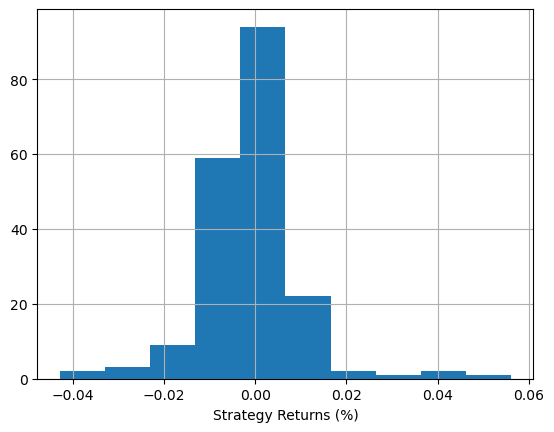

In [34]:
data['strategy_returns'] = data.percent_change.shift(-1) *model.predict(X)

data.strategy_returns[split:].hist()

plt.xlabel('Strategy Returns (%)')

plt.show()

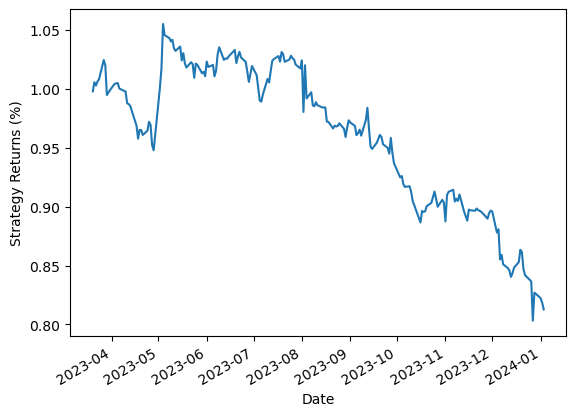

In [35]:
(data.strategy_returns[split:]+1).cumprod().plot()

plt.ylabel('Strategy Returns (%)')

plt.show()

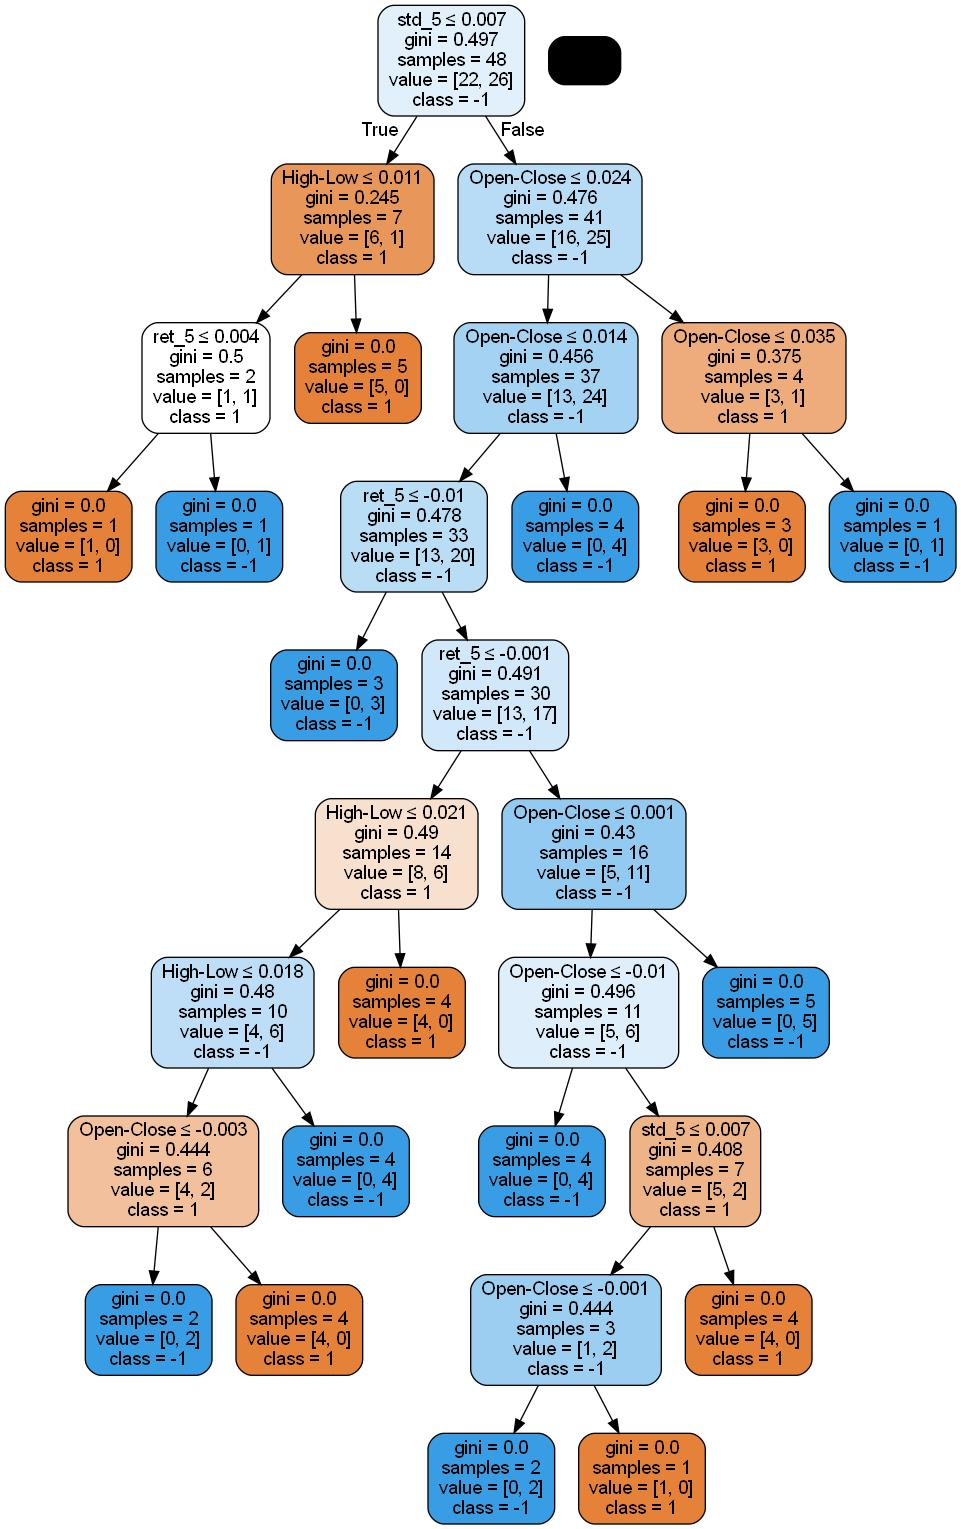

In [36]:
'''
## Plotting the Decision Tree Model Graph
'''

dot_data = StringIO()

export_graphviz(clf, out_file= dot_data,
                filled = True, rounded = True,
                special_characters= True, feature_names= feature_cols, class_names= ['1', '-1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_jpg('US.jpg')

Image(graph.create_jpg())